In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.stats as stats

import pandas as pd

from tqdm import tqdm

plt.rcParams.update({
    'figure.figsize':(7,7),
    'xtick.major.width':1,
    'ytick.major.width':1,
    'xtick.minor.width':1,
    'ytick.minor.width':1,
    'xtick.major.size':8,
    'ytick.major.size': 6,
    'xtick.minor.size':3,
    'ytick.minor.size':3,
    'font.family':'STIXGeneral',
    'font.size':16,
#    'xtick.top':True,
#    'ytick.right':True,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'mathtext.fontset': 'cm',
    'mathtext.rm': 'serif'})   

def make_plot_nice(ax):
    """
    """    
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')  # or 'bottom'                                                    
    ax.tick_params(direction='in',axis='both',which='minor',length=3,width=1,labelsize=14)
    ax.tick_params(direction='in',axis='both',which='major',length=6,width=1,labelsize=14)
    ax.minorticks_on()  
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)

    return

from sklearn.model_selection import train_test_split

import seaborn as sns

import itertools
from matplotlib.lines import Line2D
import random
import matplotlib.colors as mcolors

import astropy.constants as const
import astropy.units as u

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec

In [2]:
# load data, get features, labels
dat = np.load('data/trts_data_with_errors.npz')
features = dat['features'] ### 20 RVs, 20 timestamps

labels = dat['labels'] ### v0, K, w, phi_0, e, P

### we'll want to train on log period, i think:
logPs = np.log10(labels[:,-1:])
labels = np.hstack([labels[:,:-1], logPs])

## Prepare network inputs

We'll want to be able to easily normalize and un-normalize the data. As well, since normalizing by the min/max of each input removes information about the velocity amplitude and systemic velocity, we'll create additional input features to trace those. Inputs are normalized input-by-input, whereas outputs are normalized based on the min/max of each parameter in the training sample. (so we must save those so that test data can be un-normalized correctly).

In [5]:
### step 1: normalize features. 
### the inputs may be normalized independently 
### times can just go from 0 to 1, and I will "normalize" RVs by taking 
### ### RV_norm = (RV - mean(RV))/mean(RVmax, RV_min)
### the outputs must be normalized and unnormalized by the original training data, column-wise.

def normalize_inputs(input_data):
    """
    input_data must be a numpy array of shape (N, 40)
    where the first 20 columns are RVs 
    and the second 20 columns are times of the observations
    """
    input_RVs = input_data[:,0:20]
    input_times = input_data[:,20:]

    normed_rvs = []
    normed_times = []
    v0_ests = []
    K_ests = []
    for i in range(input_data.shape[0]):
        v = input_RVs[i]
        v_max = max(v)
        v_min = min(v)
        v0_est = np.mean(v)
        v0_ests.append([v0_est])
        K_est = (v_max - v_min)/2#np.mean(np.array([v_max, v_min]))
        K_ests.append([K_est])
        # v_norm = (v - v0_est)/K_est
        v_norm = (v-v_min)/(v_max - v_min)
        normed_rvs.append(v_norm)
        # normed_rvs.append(v)

        t = input_times[i]
        t_max = max(t)
        t_min = min(t)
        t_norm = (t - t_min)/(t_max - t_min)
        normed_times.append(t_norm)
    normed_rvs = np.array(normed_rvs)
    normed_times = np.array(normed_times)
    v0_ests = np.array(v0_ests)
    K_ests = np.array(K_ests)

    return np.hstack([normed_rvs, normed_times, v0_ests, K_ests]) ### give the network information about v0 and K

def normalize_outputs(output_data, training_data, normalize_linears=True):
    """
    normalize outputs based on the min/max of the training data
    normalized column-wise (ie so that all orbital periods are btwn 0--1, etc)
    normalize_linears: bool, whether to normalize the linear parameters v0, K
    """
    if normalize_linears==True:
        max_tr = np.max(training_data, axis=0)
        min_tr = np.min(training_data, axis=0)

        normed_outputs = (output_data - min_tr)/(max_tr - min_tr)
    if normalize_linears==False:
        linear_params = training_data[:,0:2]
        nonlinear_params = training_data[:,2:]
        max_nonlin = np.max(nonlinear_params, axis=0)
        min_nonlin = np.min(nonlinear_params, axis=0)
        normed_nonlin = (nonlinear_params - min_nonlin) / (max_nonlin - min_nonlin)
        normed_outputs = np.hstack([linear_params, normed_nonlin])
    return normed_outputs

def unnormalize_outputs(output_data, training_data, normalize_linears=True):
    if normalize_linears==True:
        max_tr = np.max(training_data, axis=0)
        min_tr = np.min(training_data, axis=0)

        unnormed_outputs = (output_data*(max_tr - min_tr)) + min_tr

    if normalize_linears==False:
        nonlinears_tr = training_data[:,2:]
        max_nonlin = np.max(nonlinears_tr, axis=0)
        min_nonlin = np.min(nonlinears_tr, axis=0)

        linears_output = output_data[:,0:2]
        nonlinears_output = output_data[:,2:]

        unnormed_nonlin = (nonlinears_output * (max_nonlin - min_nonlin)) + min_nonlin
        unnormed_outputs = np.hstack([linears_output, unnormed_nonlin])
    return unnormed_outputs


In [6]:
# Perfrom a train/test split with sklearn:
### perform the train/test split prior to normalizing
X_train_unnorm, X_test_unnorm, y_train_unnorm, y_test_unnorm = train_test_split(
    features, labels,test_size=0.2, random_state=33
    )

In [7]:
## normalize training and test data
X_train_numpy = normalize_inputs(X_train_unnorm)
X_test_numpy = normalize_inputs(X_test_unnorm)

y_train_numpy = normalize_outputs(y_train_unnorm, y_train_unnorm)
y_test_numpy = normalize_outputs(y_test_unnorm, y_train_unnorm)

In [8]:
### prepare torch objects
X_train = torch.from_numpy(X_train_numpy).to(torch.float32)
X_test = torch.from_numpy(X_test_numpy).to(torch.float32)
y_train = torch.from_numpy(y_train_numpy).to(torch.float32)
y_test = torch.from_numpy(y_test_numpy).to(torch.float32)

training_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

BATCHSIZE = 128
BATCHSIZE_TEST = 256

train_dataloader = DataLoader(training_dataset, batch_size=BATCHSIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCHSIZE_TEST, shuffle=True)

## Build and train the MLP

In [9]:
input_size = X_train.shape[1] ### features does not include v0_est, K_est
hidden_size1 = 20
# hidden_size2 = 20
# hidden_size3 = 10
# hidden_size4 = 10
output_size = labels.shape[1]
# print(input_size, ">", hidden_size1, ">", hidden_size2, ">", hidden_size3, ">", hidden_size4, ">", output_size)
print(input_size, ">", hidden_size1, ">", output_size)

42 > 20 > 6


In [10]:
class Network(nn.Module):
    def __init__(self, seed=33):
        super(Network, self).__init__() # idk what this does
        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, output_size)

        # We will initialize weights following a multivariate Gaussian
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)


    def forward(self, x):
        x = torch.nn.LeakyReLU()(self.fc1(x))
        y = self.fc2(x)
        return y

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size=len(dataloader.dataset)
    losses = []

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction of the model
        pred = model(X)
        # Compute the loss function
        loss = loss_fn(pred,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ### track loss
        if batch%100==0:
            loss, current = loss.item(), batch*len(X)
            losses.append(loss)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return losses

# the test loop is similar to the training loop, only that we don't take any gradients/don't update the network parameters, but only evaluate
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss =  0
    with torch.no_grad():
        for (X, y) in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    # print(f" Avg loss: {test_loss:>8f} \n")

    return test_loss

In [12]:
MODEL = Network()

EPOCHS = 1000
LEARNING_RATE = 1e-5 # for initial baseline training. 

# MeanSquaredError (L2) Loss
loss_fn         = nn.MSELoss()
# Adam Optimizer
optimizer       = torch.optim.Adam(MODEL.parameters(), lr=LEARNING_RATE)

train_loss = []
test_loss  = []
for t in tqdm(range(EPOCHS)):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, MODEL, loss_fn, optimizer))
    test_loss.append(test_loop(test_dataloader, MODEL, loss_fn))
print("Done!")

100%|██████████| 1000/1000 [46:58<00:00,  2.82s/it]

Done!


## Assess model performance

In [13]:
tr_loss = np.mean(np.array(train_loss), axis=1)
# tr_loss

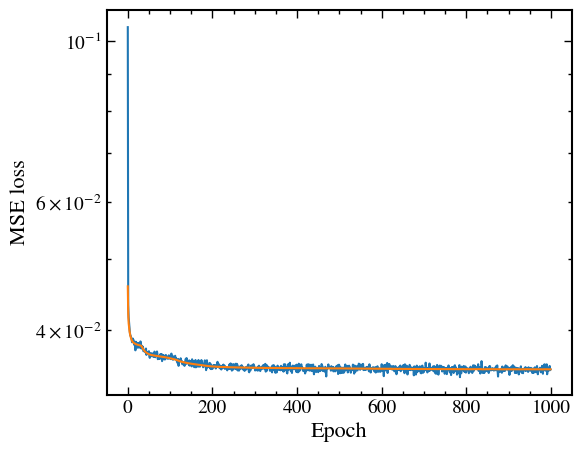

In [14]:
fig, ax = plt.subplots(figsize=[6,5])
iters = np.arange(0, EPOCHS, 1)
ax.plot(iters, tr_loss)
ax.plot(iters, test_loss)
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE loss')

make_plot_nice(ax)

-126.99852138841102 142.82296263739954
0.0017476241706876649 486.6134816952517
7.332080251532577e-05 6.283182627125814
3.844573410294316e-06 0.9999990971602517
0.0001049481884528 0.9893129142026734
0.1500192249448513 7.999704200457086


Text(0.07, 0.5, 'Predicted')

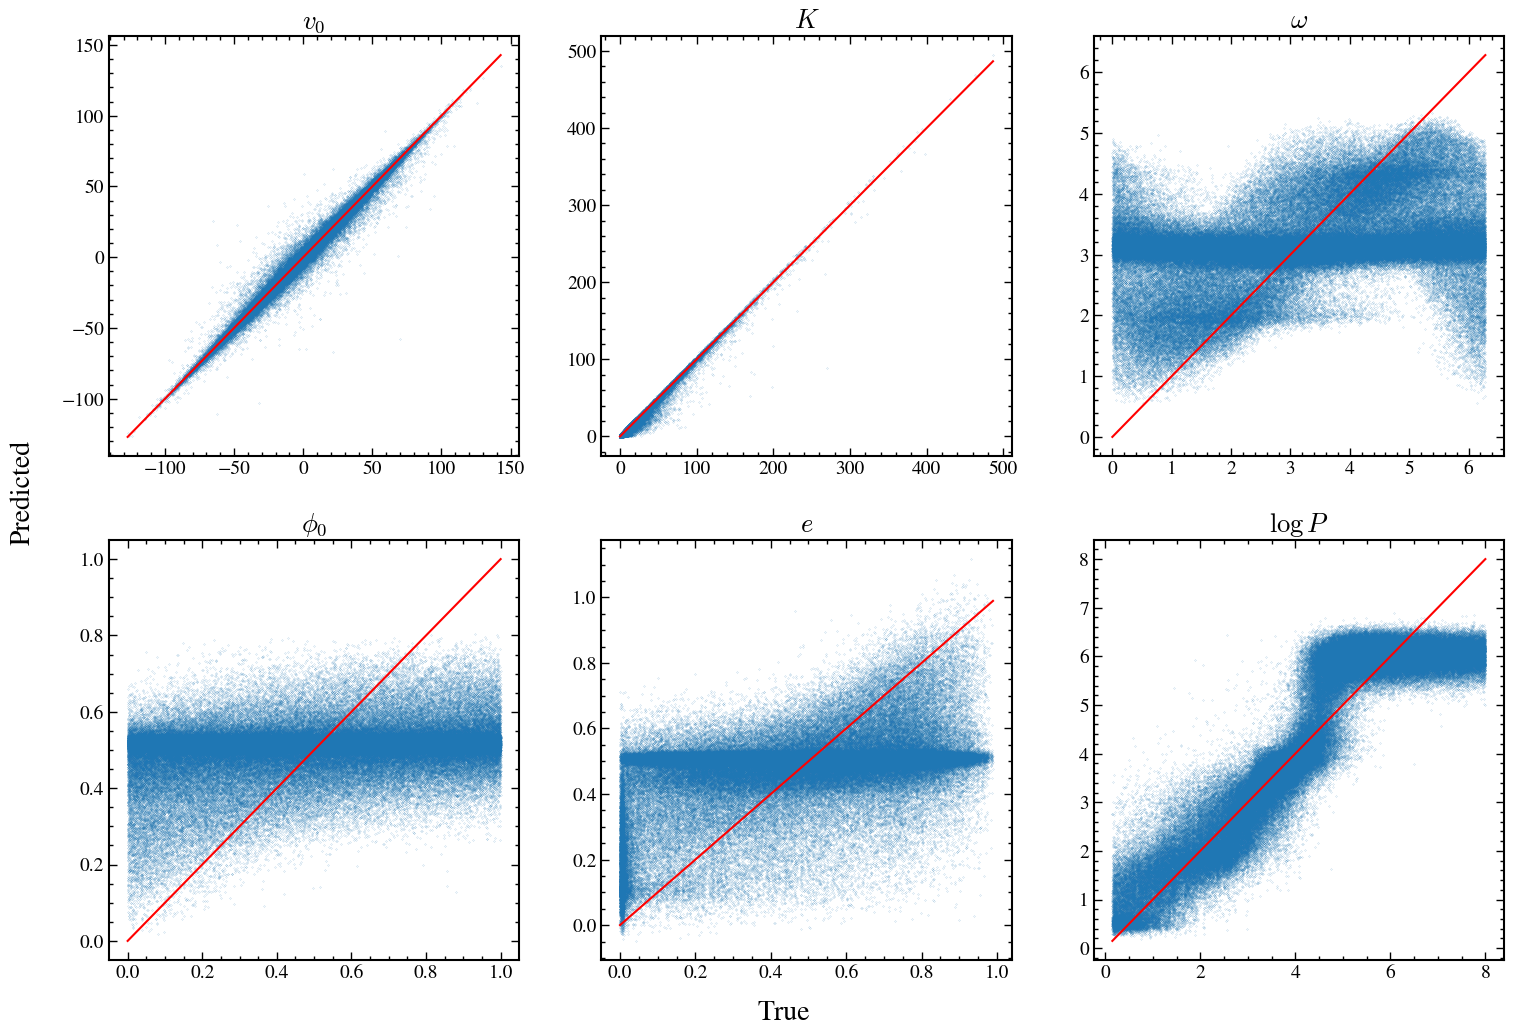

In [17]:
### plot different params predicted vs true.

y_pred = MODEL(X_test.detach()).detach()

y_pred_numpy = y_pred.numpy()
y_pred_unnormalized = unnormalize_outputs(y_pred_numpy, y_train_unnorm)


fig, [[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3, figsize=[18,12])
ax_list = [ax1,ax2,ax3,ax4,ax5,ax6]
param_names = [r"$v_0$", r"$K$", r'$\omega$', r'$\phi_0$', r'$e$', r'$\log{P}$']
for i in range(y_pred.shape[1]):
    ax = ax_list[i]
    ax.scatter(y_test_unnorm[:,i], y_pred_unnormalized[:,i], s=.01,zorder=0)
    ax.set_title(param_names[i])
    make_plot_nice(ax) 

    mi = min(y_test_unnorm[:,i])
    ma = max(y_test_unnorm[:,i])
    print(mi, ma)
    ax.plot([mi,ma],[mi,ma], c='r')   

fig.text(0.5, 0.06, "True", ha='center', fontsize=20)
fig.text(0.07, 0.5, "Predicted", rotation='vertical', va='center', fontsize=20)

# ax2.set_ylim(-100,500)
# ax2.set_xscale('log')
# ax2.set_yscale('log')
# ax6.set_xscale('log')
# ax6.set_yscale('log')

In [18]:
## save the model
torch.save(MODEL.state_dict(), "models/baseline_MLP.pth")

### make a nice plot

In [20]:
MODEL = Network()
MODEL.load_state_dict(torch.load('models/baseline_MLP.pth'))
MODEL.eval()

Network(
  (fc1): Linear(in_features=42, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=6, bias=True)
)

-126.99852138841102 142.82296263739954
0.0017476241706876649 486.6134816952517
7.332080251532577e-05 6.283182627125814
3.844573410294316e-06 0.9999990971602517
0.0001049481884528 0.9893129142026734
0.1500192249448513 7.999704200457086


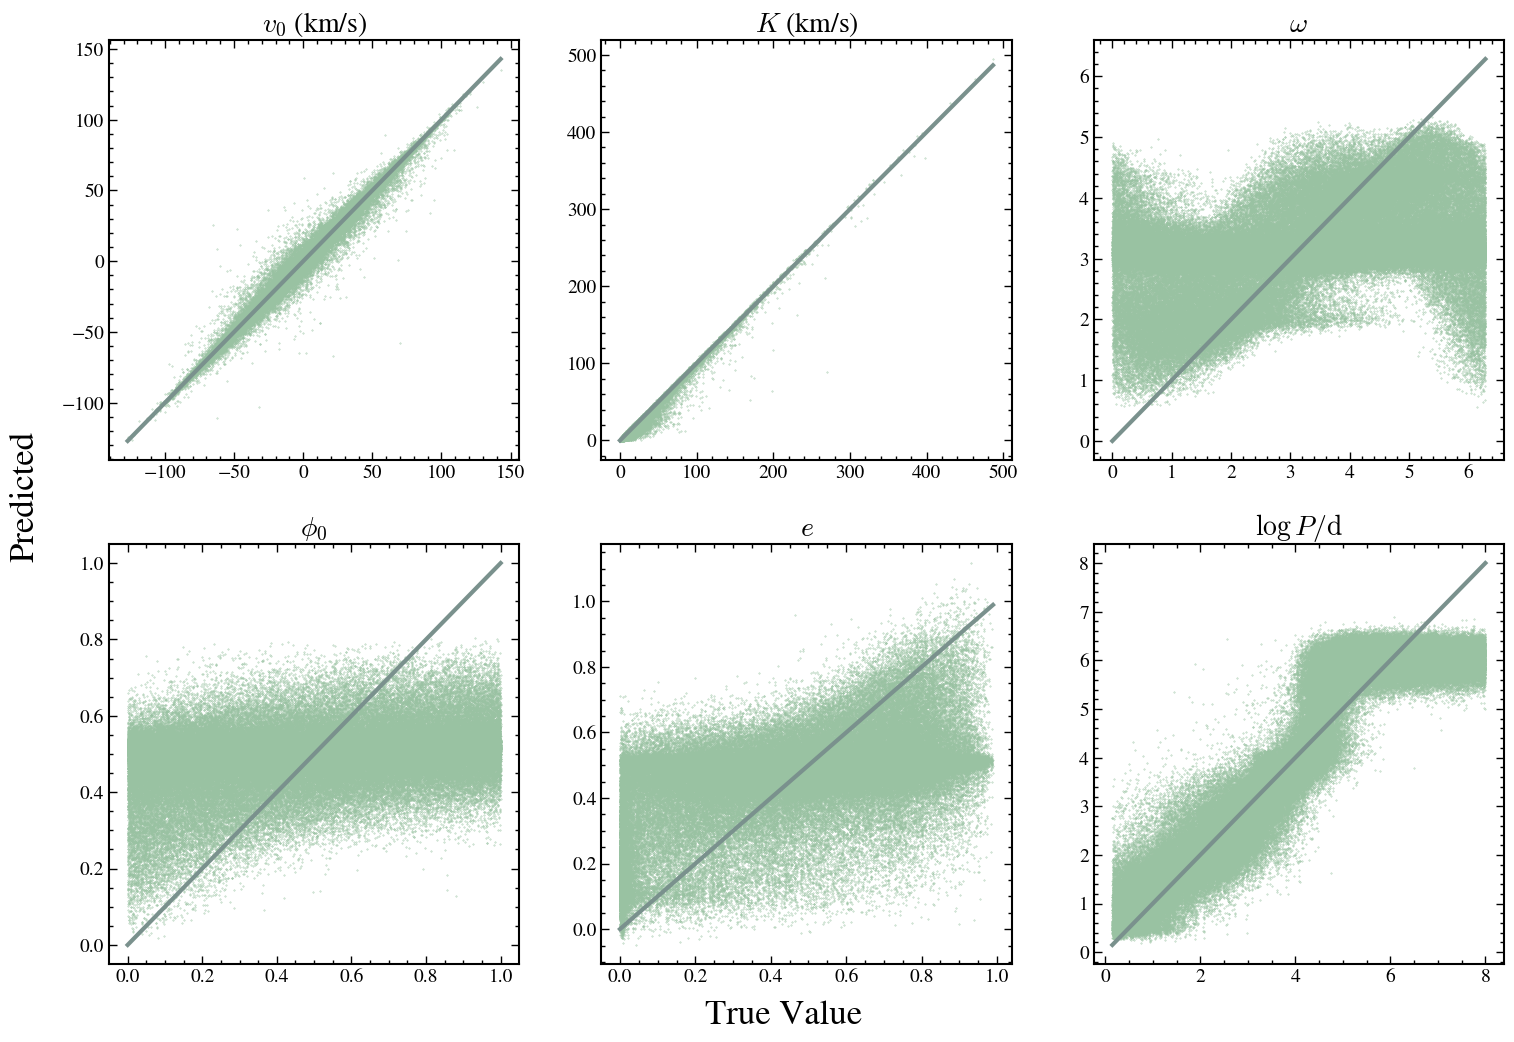

In [23]:
y_pred = MODEL(X_test.detach()).detach()

y_pred_numpy = y_pred.numpy()
y_pred_unnormalized = unnormalize_outputs(y_pred_numpy, y_train_unnorm)


fig, [[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3, figsize=[18,12])
ax_list = [ax1,ax2,ax3,ax4,ax5,ax6]
param_names = [r"$v_0$ (km/s)", r"$K$ (km/s)", r'$\omega$', r'$\phi_0$', r'$e$', r'$\log{P/\rm{d}}$']
for i in range(y_pred.shape[1]):
    ax = ax_list[i]
    # if i==2 or i==3 or i==4 or i==5:
    ax.scatter(y_test_unnorm[:,i], y_pred_unnormalized[:,i], s=.1,zorder=0, c='#99C2A2',rasterized=True)
    
    

    mi = min(y_test_unnorm[:,i])
    ma = max(y_test_unnorm[:,i])
    print(mi, ma)
    ax.plot([mi,ma],[mi,ma], c='#7A918D', linewidth=3) 
    ax.set_title(param_names[i], fontsize=20) 
    make_plot_nice(ax)  



fig.text(0.5, 0.06, "True Value", ha='center', fontsize=25)
fig.text(0.07, 0.5, "Predicted", rotation='vertical', va='center', fontsize=25)
plt.savefig('plots/baseline_performance.pdf', dpi=300, bbox_inches="tight")
plt.savefig('plots/baseline_performance.png', dpi=300, bbox_inches="tight")